xgboost model to prediction store level sales without difference to comp_date sales
----------

In [1]:
import pandas as pd
import math
import xgboost as xgb
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
# File names for sales, calendar and holiday
store_id = 1
file_sales = '../../Willis/StoreWillisFinAdV1.0/store_sales_withPO/sales_store_withPO_' + str(store_id) + '.csv'
file_calendar = '../../Willis/StoreWillisFinAdV1.0/store_sales_withPO/calendar_withPO.csv'
file_holiday = '../../Willis/StoreWillisFinAdV1.0/store_sales_withPO/holiday_withPO.csv'

# Read in sales, calendar and holiday csv files
sales = pd.read_csv(file_sales)
calendar = pd.read_csv(file_calendar)
holiday = pd.read_csv(file_holiday)

# Drop annoying column
sales.drop('Unnamed: 0', inplace=True, axis=1)
calendar.drop('Unnamed: 0', inplace=True, axis=1)
holiday.drop('Unnamed: 0', inplace=True, axis=1)

In [4]:
# Define global variables
startdate_sales = '2014-03-02'
startdate_train = '2015-02-01'
startmonth_model = 201602

easter_days = ['2012-04-08', '2013-03-31', '2014-04-20', '2015-04-05', '2016-03-27', '2017-04-16', '2018-04-01']
christmas_days = ['2012-12-25', '2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25', '2017-12-25', '2018-12-25']
thanksgiving_days = ['2012-11-22', '2013-11-28', '2014-11-27', '2015-11-26', '2016-11-24', '2017-11-23', '2018-11-22']

In [5]:
# Get sales DataFrame

sales = sales.merge(calendar, on='Date')
sales = sales.merge(holiday, on='Date')
sales_hold = sales.copy(deep=True)

sales.rename(columns={'kc_sales':'net_chrgd_amt', 'po_kc_sales':'po_net_chrgd_amt', 
                      'po_date_c_x':'po_Date'}, inplace=True)

non_feature_cols = ['Date', 'net_chrgd_amt', 'po_net_chrgd_amt', 'po_Date', 'fscl_mn_id', 'fscl_qtr_id']
event_names = [i for i in calendar.columns.tolist() if 'po_' not in i and i != 'Date']
holiday_names = [i for i in holiday.columns.tolist() if 'po_' not in i and i != 'Date']

sales = sales[non_feature_cols + event_names + holiday_names]

In [6]:
sales['trn_sls_dte'] = pd.to_datetime(sales['Date'], infer_datetime_format=True)

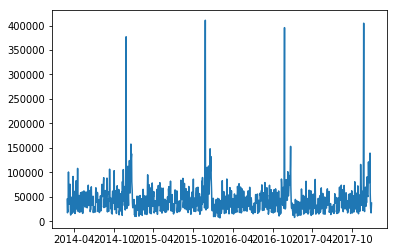

In [7]:
plt.plot(sales.trn_sls_dte, sales.net_chrgd_amt)
plt.show()

In [8]:
data_X = sales[event_names + holiday_names]
data_y = sales['net_chrgd_amt']

train_data, test_data, train_label, test_label = train_test_split(data_X, data_y, 
                                                                    test_size=0.1, random_state=42)

dtrain = xgb.DMatrix(train_data, label=train_label)
dtest = xgb.DMatrix(test_data, label=test_label)

# xgb model parameters
evallist = [(dtest, 'eval'), (dtrain, 'train')]
param = {'max_depth': 5, 'eta': 0.05, 'silent': 1, 'objective': 'reg:linear', 'subsample': 0.8}
param['nthread'] = 4
param['eval_metric'] = 'mae'  # 'rmse'

# Train model
num_round = 1000
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10)

[0]	eval-mae:41045.9	train-mae:38972.7
Multiple eval metrics have been passed: 'train-mae' will be used for early stopping.

Will train until train-mae hasn't improved in 10 rounds.
[1]	eval-mae:39078.8	train-mae:37081.2
[2]	eval-mae:37197.7	train-mae:35275.6
[3]	eval-mae:35376.8	train-mae:33545.2
[4]	eval-mae:33618.5	train-mae:31898.2
[5]	eval-mae:32004	train-mae:30358.2
[6]	eval-mae:30469.6	train-mae:28880.4
[7]	eval-mae:28994.6	train-mae:27468.9
[8]	eval-mae:27594.8	train-mae:26144.9
[9]	eval-mae:26245.6	train-mae:24883.9
[10]	eval-mae:24954.3	train-mae:23669.9
[11]	eval-mae:23745.3	train-mae:22530
[12]	eval-mae:22581.6	train-mae:21459
[13]	eval-mae:21529.8	train-mae:20455.6
[14]	eval-mae:20519.2	train-mae:19505.9
[15]	eval-mae:19556.3	train-mae:18607.4
[16]	eval-mae:18634.5	train-mae:17761.2
[17]	eval-mae:17824.8	train-mae:16972.1
[18]	eval-mae:17049.5	train-mae:16228.9
[19]	eval-mae:16349.3	train-mae:15562.1
[20]	eval-mae:15669.9	train-mae:14926.3
[21]	eval-mae:15016.2	train-mae:1

[201]	eval-mae:8026.2	train-mae:7526.5
[202]	eval-mae:8034.38	train-mae:7524.27
[203]	eval-mae:8037.42	train-mae:7524.55
[204]	eval-mae:8037.45	train-mae:7523.1
[205]	eval-mae:8034.16	train-mae:7522.02
[206]	eval-mae:8037.78	train-mae:7521.7
[207]	eval-mae:8038.18	train-mae:7519.85
[208]	eval-mae:8039.8	train-mae:7516.66
[209]	eval-mae:8048.94	train-mae:7513.59
[210]	eval-mae:8049.52	train-mae:7506.29
[211]	eval-mae:8027.46	train-mae:7502.38
[212]	eval-mae:8018.32	train-mae:7503.31
[213]	eval-mae:8022.21	train-mae:7504.48
[214]	eval-mae:8016.35	train-mae:7498.39
[215]	eval-mae:8018.03	train-mae:7495.06
[216]	eval-mae:8025.59	train-mae:7493.17
[217]	eval-mae:8018.42	train-mae:7490.62
[218]	eval-mae:8021.79	train-mae:7490.29
[219]	eval-mae:8015.7	train-mae:7487.73
[220]	eval-mae:8016.6	train-mae:7487.54
[221]	eval-mae:8011.68	train-mae:7484.62
[222]	eval-mae:8013.63	train-mae:7480.87
[223]	eval-mae:8009.27	train-mae:7476.19
[224]	eval-mae:8008.15	train-mae:7472.57
[225]	eval-mae:8005.77	

[402]	eval-mae:8183.2	train-mae:7268.24
[403]	eval-mae:8184.03	train-mae:7266.63
[404]	eval-mae:8190.29	train-mae:7264.91
[405]	eval-mae:8199.54	train-mae:7265.52
[406]	eval-mae:8192.6	train-mae:7265.1
[407]	eval-mae:8192.29	train-mae:7264.37
[408]	eval-mae:8190.87	train-mae:7264.28
[409]	eval-mae:8183.2	train-mae:7263.37
[410]	eval-mae:8173.88	train-mae:7263.32
[411]	eval-mae:8162.03	train-mae:7262.83
[412]	eval-mae:8158.73	train-mae:7259.45
[413]	eval-mae:8162.98	train-mae:7261.21
[414]	eval-mae:8164.72	train-mae:7262.02
[415]	eval-mae:8162.32	train-mae:7262.55
[416]	eval-mae:8164.86	train-mae:7262.1
[417]	eval-mae:8159.03	train-mae:7260.52
[418]	eval-mae:8158.31	train-mae:7259.37
[419]	eval-mae:8158.02	train-mae:7260.31
[420]	eval-mae:8164.44	train-mae:7257.5
[421]	eval-mae:8172.36	train-mae:7255.4
[422]	eval-mae:8172.86	train-mae:7258.06
[423]	eval-mae:8162.44	train-mae:7255.54
[424]	eval-mae:8164.59	train-mae:7254.49
[425]	eval-mae:8168.63	train-mae:7253.8
[426]	eval-mae:8161.38	t

In [9]:
# Get prediction for each of the month
ypred = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)
df_pred_t = pd.DataFrame(test_label)
df_pred_t = df_pred_t.assign(pred=list(ypred))
df_pred_t['diff'] = df_pred_t['pred'] / df_pred_t['net_chrgd_amt'] - 1
df_pred_t['abs_diff'] = df_pred_t['diff'].map(lambda x: abs(x))

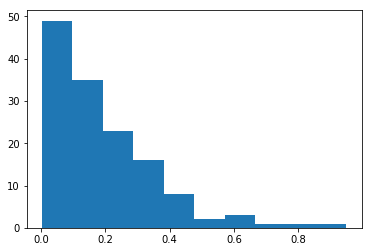

In [10]:
counts, bins , fig = plt.hist(df_pred_t['abs_diff'])